In [1]:
!pip3 install --user keras scikit-learn pandas opencv-python

     |████████████████████████████████| 378kB 7.9MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 18.6MB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 81.6MB/s eta 0:00:01
     |████████████████████████████████| 28.2MB 39.9MB/s eta 0:00:01
     |████████████████████████████████| 276kB 9.1MB/s eta 0:00:01
     |████████████████████████████████| 296kB 19.0MB/s eta 0:00:01
     |████████████████████████████████| 512kB 24.0MB/s eta 0:00:01
Failed to build pyyaml
    Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
# import the necessary packages

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.layers import Input, AveragePooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
#import cv2

Using TensorFlow backend.


In [2]:
np.random.seed(42)

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Load data: images and labels

data = []
labels = []

In [4]:
data = np.array(np.load("../data/all_images_kimeye.npy"))
labels = np.array(np.load("../data/all_labels_kimeye.npy"))
labels = labels.astype(int)

In [53]:
"""
data2 = np.array(np.load("../data/all_images_acrima.npy"))
labels2 = np.array(np.load("../data/all_labels_acrima.npy"))
labels2 = labels2.astype(int)
"""

'\ndata2 = np.array(np.load("../data/all_images_acrima.npy"))\nlabels2 = np.array(np.load("../data/all_labels_acrima.npy"))\nlabels2 = labels2.astype(int)\n'

In [54]:
"""
data = np.concatenate((data1, data2), axis=0)
labels = np.concatenate((labels1, labels2), axis=0)
"""
print(data.shape)
print(labels[0])

(1544, 224, 224, 3)
0


In [5]:
# shuffle the whole dataset

shuffle = list(zip(data, labels))
np.random.seed(42)
np.random.shuffle(shuffle)
data = np.array([shuffle[i][0] for i in range(len(shuffle))])
labels = np.array([shuffle[i][1] for i in range(len(shuffle))])
del shuffle


In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np_utils.to_categorical(labels)

data = np.array(data)
print(labels)
#labels = np.array(labels)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [57]:
"""
plt.imshow(data[254])
plt.show()
print(labels[254])

plt.imshow(data[1])
plt.show()
print(labels[1])
"""

'\nplt.imshow(data[254])\nplt.show()\nprint(labels[254])\n\nplt.imshow(data[1])\nplt.show()\nprint(labels[1])\n'

In [7]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
	test_size=0.25, random_state=42)

"""
plt.grid(None)

plt.imshow(trainX[10])
plt.show()
print(trainY[10])

plt.grid(None)

plt.imshow(testX[276])
plt.show()
print(testY[276])

plt.grid(None)

plt.imshow(testX[208])
plt.show()
print(testY[208])
"""

'\nplt.grid(None)\n\nplt.imshow(trainX[10])\nplt.show()\nprint(trainY[10])\n\nplt.grid(None)\n\nplt.imshow(testX[276])\nplt.show()\nprint(testY[276])\n\nplt.grid(None)\n\nplt.imshow(testX[208])\nplt.show()\nprint(testY[208])\n'

In [8]:
# initialize the training data augmentation object

trainAug = ImageDataGenerator(
	rotation_range=40,
	zoom_range=0.2,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32)]


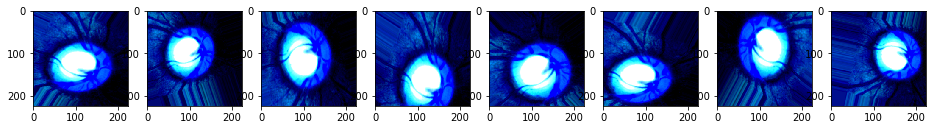

In [10]:
# visualize the different geometric transformations operated to the images

img_id = 600
cat_generator = trainAug.flow(trainX[img_id:img_id+1], 
 trainY[img_id:img_id+1], 
 batch_size=1) 
cat = [next(cat_generator) for i in range(0,8)] 
fig, ax = plt.subplots(1,8, figsize=(16, 6))

print('Labels:', [item[1][0] for item in cat]) 
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,8)]

In [89]:
# load InceptionV3, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network
baseModel = DenseNet121(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [90]:
# show a summary of the base model
print("[INFO] summary for base model...")
print(baseModel.summary())

[INFO] summary for base model...
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 230, 230, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_23[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________

In [91]:
# construct the head of the model that will be placed on top of the
# the base model

layer_index = -1
headModel = baseModel.layers[layer_index].output

headModel = GlobalAveragePooling2D()(headModel)

# let's add a fully-connected layer
hidden_units = 512
dropout_rate = 0.5

headModel = Dense(hidden_units, activation='relu')(headModel)
headModel = Dropout(dropout_rate)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [92]:
print(len(baseModel.layers))

427


In [93]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
   layer.trainable = False

In [94]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 230, 230, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_23[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [60]:
callbacks =  [EarlyStopping(monitor='val_loss', patience=20, verbose=1,  mode='auto'),
            ]

In [95]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)

print("[INFO] compiling model...")
lr = 1e-5
momentum = 0.9
decay=1e-6
opt = SGD(lr=lr, momentum=momentum, decay=decay)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
opt_name, _ = str(opt)[18:].split(' ', 1)
print(opt_name)

[INFO] compiling model...
SGD


In [ ]:
epochs = 100
batch_size = 8

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)

[INFO] training head...
Epoch 1/100
144/144 [==============================] - 31s 217ms/step - loss: 0.8427 - accuracy: 0.5730 - val_loss: 0.6655 - val_accuracy: 0.4516
Epoch 2/100
144/144 [==============================] - 24s 167ms/step - loss: 0.7945 - accuracy: 0.5704 - val_loss: 0.7380 - val_accuracy: 0.4866
Epoch 3/100
144/144 [==============================] - 25s 171ms/step - loss: 0.7390 - accuracy: 0.5922 - val_loss: 0.7363 - val_accuracy: 0.4993
Epoch 4/100
144/144 [==============================] - 30s 209ms/step - loss: 0.7067 - accuracy: 0.6296 - val_loss: 0.7810 - val_accuracy: 0.4993
Epoch 5/100
144/144 [==============================] - 32s 224ms/step - loss: 0.6592 - accuracy: 0.6452 - val_loss: 0.6332 - val_accuracy: 0.5141
Epoch 6/100
100/144 [===================>..........] - ETA: 4s - loss: 0.6700 - accuracy: 0.6479

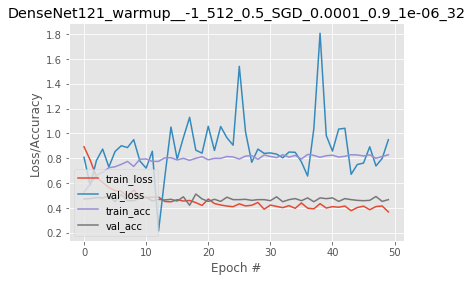

In [88]:
# plot the training loss and accuracy

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
title = "DenseNet121_warmup_" + '_' + str(layer_index) + '_' + str(hidden_units) + '_' + str(dropout_rate) + '_' + opt_name + '_' + str(lr) + '_' + str(momentum) + '_' + str(decay) + '_' + str(batch_size)
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig('../evaluation/DenseNet121/plots/' + title + '.png')

In [26]:
# evaluate the network

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
print(predictions)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1)))


[INFO] evaluating network...
[[0.33139575 0.66860425]
 [0.45574722 0.5442528 ]
 [0.37026557 0.62973446]
 [0.4438327  0.5561673 ]
 [0.3876532  0.6123468 ]
 [0.38338402 0.616616  ]
 [0.4042963  0.5957037 ]
 [0.26701504 0.73298496]
 [0.5523726  0.44762743]
 [0.28253493 0.71746504]
 [0.33656386 0.6634361 ]
 [0.5192041  0.48079595]
 [0.30800962 0.6919904 ]
 [0.48522544 0.51477456]
 [0.24252878 0.75747126]
 [0.43324554 0.56675446]
 [0.32394955 0.6760504 ]
 [0.40868783 0.59131217]
 [0.43767282 0.5623272 ]
 [0.51118004 0.48881996]
 [0.3043829  0.6956171 ]
 [0.39209616 0.6079039 ]
 [0.45822304 0.54177696]
 [0.3338397  0.66616035]
 [0.38294762 0.6170524 ]
 [0.45027962 0.5497204 ]
 [0.27861062 0.7213894 ]
 [0.23022021 0.76977986]
 [0.3098199  0.6901801 ]
 [0.35737282 0.6426271 ]
 [0.29544818 0.7045518 ]
 [0.24413612 0.7558639 ]
 [0.61767197 0.382328  ]
 [0.43725497 0.56274503]
 [0.41886932 0.5811306 ]
 [0.36908278 0.6309172 ]
 [0.31506544 0.6849345 ]
 [0.1897975  0.8102025 ]
 [0.27606207 0.723937

In [ ]:
score = model.evaluate(testX, testY,batch_size=32, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
model.save_weights("../models/DenseNet121/DenseNet121_warmed_up_weights_" + title + ".h5")

In [ ]:
baseModel2 = DenseNet121(weights=None, include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model

layer_index = -1
headModel2 = baseModel2.layers[layer_index].output

headModel2 = GlobalAveragePooling2D()(headModel2)

# let's add a fully-connected layer
hidden_units = 512
dropout_rate = 0.5

headModel2 = Dense(hidden_units, activation='relu')(headModel2)
headModel2 = Dropout(dropout_rate)(headModel2)
headModel2 = Dense(2, activation="softmax")(headModel2)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model2 = Model(inputs=baseModel2.input, outputs=headModel2)

In [ ]:
model2.load_weights("../models/DenseNet121/DenseNet121_warmed_up_weights_DenseNet121_warmup__-1_512_0.5_SGD_0.0001_0.9_1e-06_64.h5")

In [ ]:
model2.summary()

In [ ]:
# initialize the training data augmentation object

trainAug2 = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug2 = ImageDataGenerator()

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(baseModel2.layers):
   print(i, layer.name)

In [27]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers:
   layer.trainable = True

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [29]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [31]:
epochs = 200
#batch_size = 32

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)

[INFO] training head...
Epoch 1/200
144/144 [==============================] - 66s 461ms/step - loss: 0.5098 - accuracy: 0.7539 - val_loss: 0.5809 - val_accuracy: 0.7780
Epoch 2/200
144/144 [==============================] - 32s 224ms/step - loss: 0.4901 - accuracy: 0.7704 - val_loss: 0.4083 - val_accuracy: 0.8058
Epoch 3/200
144/144 [==============================] - 32s 222ms/step - loss: 0.4915 - accuracy: 0.7696 - val_loss: 0.4914 - val_accuracy: 0.7945
Epoch 4/200
144/144 [==============================] - 32s 224ms/step - loss: 0.5119 - accuracy: 0.7470 - val_loss: 0.5011 - val_accuracy: 0.7932
Epoch 5/200
144/144 [==============================] - 32s 224ms/step - loss: 0.4913 - accuracy: 0.7713 - val_loss: 0.6143 - val_accuracy: 0.8030
Epoch 6/200
144/144 [==============================] - 32s 224ms/step - loss: 0.4710 - accuracy: 0.7939 - val_loss: 0.2552 - val_accuracy: 0.8086
Epoch 7/200
144/144 [==============================] - 32s 223ms/step - loss: 0.4726 - accuracy: 0.7

KeyboardInterrupt: 

In [ ]:
# plot the training loss and accuracy

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [ ]:
score = model.evaluate(testX, testY,batch_size=32, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
repository = 'drive/My Drive/17.png'
repository2 = 'drive/My Drive/5.png'
repository3 = 'drive/My Drive/dataset/Test/glaucomatous/drishtiGS_001.png'
repository4 = 'drive/My Drive/dataset/Training/healthy/drishtiGS_008.png'

test_image = cv2.imread(repository4)
plt.imshow(test_image)

test_image = test_image/255
test_image = np.resize(test_image, (224,224,3))
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)


pred = model.predict(test_image) # ADD CODE HERE
print(pred)
#print(preds)
label = np.argmax(pred) # ADD CODE HERE
print(label)


In [ ]:
# evaluate the network
"""
repository = 'drive/My Drive/dataset/Test/glaucomatous/drishtiGS_001.png'
repository2 = 'drive/My Drive/dataset/Training/healthy/drishtiGS_008.png'
repository3 = 'drive/My Drive/17.png'
repository4 = 'drive/My Drive/5.png'

test_image = cv2.imread(repository3)
plt.imshow(test_image)

test_image = test_image/255
test_image = np.resize(test_image, (224,224,3))
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)


pred = model.predict(test_image) # ADD CODE HERE
print(pred)
#print(preds)
label = np.argmax(pred) # ADD CODE HERE
print(label)
"""